In [1]:
import os 
import pathlib
import pickle as pkl
import cloudpickle 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, RocCurveDisplay, average_precision_score, precision_recall_curve, PrecisionRecallDisplay, balanced_accuracy_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.max_columns', None)
from bill_classification import *

In [ ]:
X_train, X_test, y_train, y_test, y_classes, bill_ls = split_features(
    feature_path = "../data/preprocessed/features.pkl", 
    block_path = "../data/preprocessed/block_array.pkl")

In [ ]:
#LSVC PIPELINE
ct = preprocess_ct()
LSVC = LinearSVC(class_weight="balanced", max_iter=1000)
clf_pipeline_LSVC= Pipeline(steps=[("preprocessor", ct), ("LSVC_classifier", LSVC)])
clf_pipeline_LSVC.fit(X_train, y_train)
LSVC_coef = LSVC.coef_ 
feature_names = ct.get_feature_names_out()

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['state']),
                                                 ('bin',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['cha', 'position']),
                                                 ('num',
                                                  Pipeline(step...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4e2892f5c0>),
                                                 ('count',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4e27c22ab0>),
                                                 ('text',
                                                  Pipeline(steps=[('encoder',
                                                                   TfidfVectorizer(min_df=0.001,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english'))]),
                                                  'descr_prep')])),
                ('LSVC_classifier', LinearSVC(class_weight='balanced'))])

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     22490
           1       0.39      0.78      0.52      3061

    accuracy                           0.83     25551
   macro avg       0.68      0.81      0.71     25551
weighted avg       0.90      0.83      0.85     25551

balanced accuracy: 0.8098
roc auc score: 0.8097844786074292


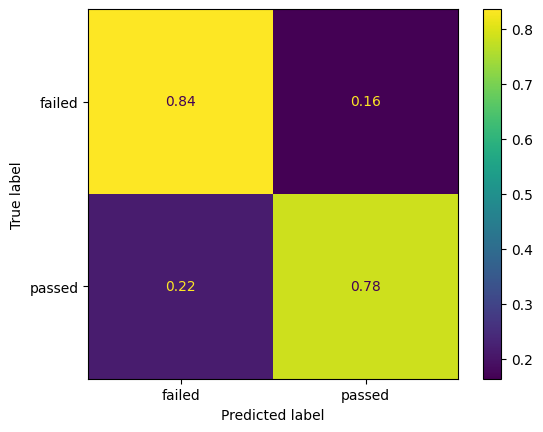

In [67]:
y_pred = clf_pipeline_LSVC.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"balanced accuracy: {round(balanced_accuracy_score(y_test, y_pred), 4)}")
print(f"roc auc score: {roc_auc_score(y_test, y_pred, average="weighted")}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["failed", "passed"], normalize="true")

In [69]:
feature_coefs = pd.DataFrame(pd.Series(feature_names).str.split("__", expand=True))
feature_coefs.rename(columns={0:"transformer", 1: 'feature'}, inplace=True)
feature_coefs["coef"] = LSVC_coef.reshape(-1,)

In [85]:
feature_coefs.loc[feature_coefs["transformer"] == "count", "feature"].str.split("_", expand=True)

,0,1,2
17,block1,146,s
18,block1,146,n
19,block1,146,o
20,block1,195,s
21,block1,195,n
...,...,...,...
420,block1,202,n
421,block1,202,o
422,block1,92,s
423,block1,92,n


In [74]:
feature_coefs.value_counts("transformer")

transformer
text     2286
count     408
num         9
cat         6
bin         2
Name: count, dtype: int64

<Axes: xlabel='feature', ylabel='coef'>

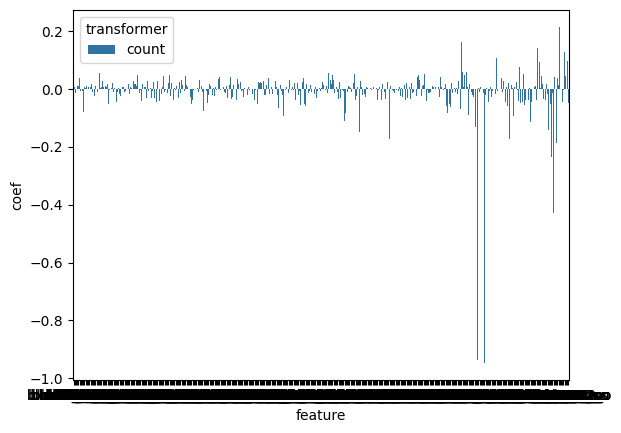

In [77]:
sns.barplot(feature_coefs[feature_coefs["transformer"] == "count"], 
            x="feature", y="coef", hue="transformer")

<Axes: xlabel='feature', ylabel='coef'>

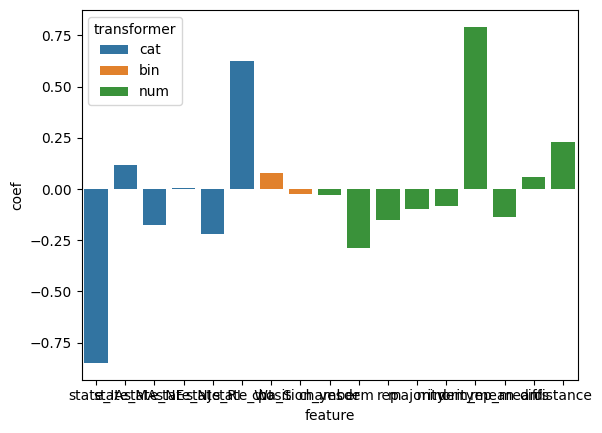

In [76]:
sns.barplot(feature_coefs[feature_coefs["transformer"].isin(["num", "cat", "bin"])], 
            x="feature", y="coef", hue="transformer")

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 3.867e+03 pre 3.736e+03 delta 5.587e+00 f 8.176e+03 |g| 1.440e+04 CG  22
cg reaches trust region boundary
iter  2 act 4.052e+02 pre 8.796e+02 delta 3.645e+00 f 4.309e+03 |g| 1.180e+03 CG  21
iter  3 act 6.658e+02 pre 6.914e+02 delta 3.645e+00 f 3.904e+03 |g| 5.297e+03 CG  13
cg reaches trust region boundary
iter  4 act 5.658e+01 pre 3.364e+02 delta 1.823e+00 f 3.238e+03 |g| 7.418e+02 CG  19
iter  5 act 3.220e+02 pre 3.319e+02 delta 1.823e+00 f 3.181e+03 |g| 5.425e+03 CG   8
cg reaches trust region boundary
iter  6 act -1.579e+02 pre 1.714e+02 delta 6.206e-01 f 2.859e+03 |g| 6.981e+02 CG  18
cg reaches trust region boundary
iter  6 act -2.098e+02 pre 8.229e+01 delta 1.552e-01 f 2.859e+03 |g| 6.981e+02 CG  10
cg reaches trust region boundary
iter  6 act -1.032e+01 pre 3.466e+01 delta 6.724e-02 f 2.859e+03 |g| 6.981e+02 CG   6
cg reaches trust region boundary
iter  6 act 2.105e+00 pre 1.969e+01 delta 3.362e-02 f 2.859e+03 |g| 6.981e+02 CG   4
cg reaches trust region

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.006e+04 pre 9.794e+03 delta 4.376e+00 f 2.657e+04 |g| 4.649e+04 CG  17
cg reaches trust region boundary
iter  2 act 2.325e+03 pre 2.553e+03 delta 4.376e+00 f 1.651e+04 |g| 4.374e+03 CG  22
cg reaches trust region boundary
iter  3 act 1.619e+03 pre 1.658e+03 delta 4.376e+00 f 1.419e+04 |g| 4.663e+03 CG  27
cg reaches trust region boundary
iter  4 act 8.715e+02 pre 9.891e+02 delta 4.376e+00 f 1.257e+04 |g| 3.007e+03 CG  30
cg reaches trust region boundary
iter  5 act 5.464e+02 pre 7.854e+02 delta 3.366e+00 f 1.170e+04 |g| 2.510e+03 CG  34
iter  6 act 4.251e+02 pre 4.381e+02 delta 3.366e+00 f 1.115e+04 |g| 6.515e+03 CG  18
cg reaches trust region boundary
iter  7 act 2.483e+02 pre 2.638e+02 delta 3.366e+00 f 1.072e+04 |g| 1.229e+03 CG  29
cg reaches trust region boundary
iter  8 act 4.730e+01 pre 3.111e+02 delta 1.683e+00 f 1.048e+04 |g| 1.602e+03 CG  40
iter  9 act 3.118e+02 pre 3.206e+02 delta 1.683e+00 f 1.043e+04 |g| 4.400e+03 CG  16
cg reaches trust region bo

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.663e+04 pre 1.627e+04 delta 4.484e+00 f 4.497e+04 |g| 7.821e+04 CG  17
cg reaches trust region boundary
iter  2 act 3.935e+03 pre 4.223e+03 delta 4.484e+00 f 2.834e+04 |g| 6.396e+03 CG  22
cg reaches trust region boundary
iter  3 act 2.397e+03 pre 2.331e+03 delta 4.618e+00 f 2.441e+04 |g| 5.421e+03 CG  28
cg reaches trust region boundary
iter  4 act 8.408e+02 pre 1.375e+03 delta 3.354e+00 f 2.201e+04 |g| 3.992e+03 CG  33
cg reaches trust region boundary
iter  5 act 1.247e+03 pre 1.299e+03 delta 3.354e+00 f 2.117e+04 |g| 4.104e+03 CG  38
cg reaches trust region boundary
iter  6 act 5.654e+02 pre 5.341e+02 delta 3.631e+00 f 1.992e+04 |g| 1.517e+03 CG  38
cg reaches trust region boundary
iter  7 act 3.386e+02 pre 3.814e+02 delta 3.631e+00 f 1.936e+04 |g| 1.162e+03 CG  41
cg reaches trust region boundary
iter  8 act 3.229e+02 pre 3.357e+02 delta 3.631e+00 f 1.902e+04 |g| 2.672e+03 CG  47
cg reaches trust region boundary
iter  9 act 2.426e+02 pre 2.345e+02 delta 3.8

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.374e+04 pre 2.330e+04 delta 4.811e+00 f 6.336e+04 |g| 1.092e+05 CG  18
cg reaches trust region boundary
iter  2 act 5.409e+03 pre 5.628e+03 delta 4.811e+00 f 3.963e+04 |g| 8.154e+03 CG  24
cg reaches trust region boundary
iter  3 act 3.035e+03 pre 2.896e+03 delta 5.166e+00 f 3.422e+04 |g| 5.410e+03 CG  31
cg reaches trust region boundary
iter  4 act 1.597e+03 pre 1.590e+03 delta 5.247e+00 f 3.118e+04 |g| 3.394e+03 CG  40
cg reaches trust region boundary
iter  5 act 9.339e+02 pre 1.079e+03 delta 5.247e+00 f 2.959e+04 |g| 2.216e+03 CG  46
cg reaches trust region boundary
iter  6 act 7.868e+02 pre 7.608e+02 delta 5.445e+00 f 2.865e+04 |g| 1.917e+03 CG  61
cg reaches trust region boundary
iter  7 act -7.592e+00 pre 3.791e+02 delta 2.695e+00 f 2.786e+04 |g| 1.411e+03 CG  77
cg reaches trust region boundary
iter  7 act 1.335e+02 pre 2.638e+02 delta 1.807e+00 f 2.786e+04 |g| 1.411e+03 CG  60
iter  8 act 1.767e+02 pre 1.729e+02 delta 1.807e+00 f 2.773e+04 |g| 3.560e+03

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.908e+04 pre 2.857e+04 delta 4.314e+00 f 8.176e+04 |g| 1.415e+05 CG  16
cg reaches trust region boundary
iter  2 act 7.335e+03 pre 7.614e+03 delta 4.314e+00 f 5.268e+04 |g| 1.215e+04 CG  22
cg reaches trust region boundary
iter  3 act 3.954e+03 pre 3.772e+03 delta 4.563e+00 f 4.534e+04 |g| 7.889e+03 CG  28
cg reaches trust region boundary
iter  4 act 2.164e+03 pre 2.068e+03 delta 4.804e+00 f 4.139e+04 |g| 9.709e+03 CG  34
cg reaches trust region boundary
iter  5 act 1.196e+03 pre 1.403e+03 delta 4.804e+00 f 3.922e+04 |g| 3.478e+03 CG  44
cg reaches trust region boundary
iter  6 act 1.058e+03 pre 1.015e+03 delta 5.057e+00 f 3.803e+04 |g| 4.068e+03 CG  51
cg reaches trust region boundary
iter  7 act 3.924e+02 pre 5.191e+02 delta 5.057e+00 f 3.697e+04 |g| 3.286e+03 CG  68
cg reaches trust region boundary
iter  8 act 4.217e+02 pre 4.118e+02 delta 5.218e+00 f 3.658e+04 |g| 1.334e+03 CG  90
cg reaches trust region boundary
iter  9 act 1.353e+02 pre 1.356e+02 delta 5.2

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 3.366e+03 pre 3.237e+03 delta 4.342e+00 f 8.176e+03 |g| 1.400e+04 CG  17
cg reaches trust region boundary
iter  2 act 7.128e+02 pre 9.283e+02 delta 4.342e+00 f 4.810e+03 |g| 1.513e+03 CG  18
cg reaches trust region boundary
iter  3 act 7.386e+02 pre 7.998e+02 delta 4.342e+00 f 4.097e+03 |g| 1.819e+03 CG  23
cg reaches trust region boundary
iter  4 act 3.650e+02 pre 5.088e+02 delta 3.402e+00 f 3.358e+03 |g| 1.332e+03 CG  25
cg reaches trust region boundary
iter  5 act 8.674e+01 pre 4.161e+02 delta 1.701e+00 f 2.993e+03 |g| 1.907e+03 CG  26
cg reaches trust region boundary
iter  6 act 3.733e+02 pre 4.321e+02 delta 1.701e+00 f 2.907e+03 |g| 1.983e+03 CG  21
cg reaches trust region boundary
iter  7 act 7.112e+01 pre 1.355e+02 delta 1.158e+00 f 2.533e+03 |g| 9.217e+02 CG  21
cg reaches trust region boundary
iter  8 act 6.531e+01 pre 1.195e+02 delta 7.998e-01 f 2.462e+03 |g| 8.011e+02 CG  19
cg reaches trust region boundary
iter  9 act 7.300e+01 pre 8.397e+01 delta 7.9

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 9.958e+03 pre 9.686e+03 delta 4.409e+00 f 2.657e+04 |g| 4.525e+04 CG  17
cg reaches trust region boundary
iter  2 act 2.291e+03 pre 2.510e+03 delta 4.409e+00 f 1.661e+04 |g| 3.811e+03 CG  21
cg reaches trust region boundary
iter  3 act 1.559e+03 pre 1.641e+03 delta 4.409e+00 f 1.432e+04 |g| 3.296e+03 CG  26
cg reaches trust region boundary
iter  4 act 1.002e+03 pre 1.060e+03 delta 4.409e+00 f 1.276e+04 |g| 5.057e+03 CG  29
cg reaches trust region boundary
iter  5 act 6.331e+02 pre 6.925e+02 delta 4.409e+00 f 1.176e+04 |g| 2.066e+03 CG  34
cg reaches trust region boundary
iter  6 act 4.251e+02 pre 5.391e+02 delta 4.409e+00 f 1.113e+04 |g| 1.949e+03 CG  40
cg reaches trust region boundary
iter  7 act 4.323e+02 pre 4.600e+02 delta 4.409e+00 f 1.070e+04 |g| 2.293e+03 CG  45
cg reaches trust region boundary
iter  8 act 1.577e+02 pre 2.717e+02 delta 3.113e+00 f 1.027e+04 |g| 9.823e+02 CG  51
cg reaches trust region boundary
iter  9 act 1.761e+02 pre 2.559e+02 delta 2.3

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.620e+04 pre 1.587e+04 delta 4.312e+00 f 4.497e+04 |g| 7.692e+04 CG  16
cg reaches trust region boundary
iter  2 act 3.945e+03 pre 4.253e+03 delta 4.312e+00 f 2.877e+04 |g| 6.847e+03 CG  22
cg reaches trust region boundary
iter  3 act 2.485e+03 pre 2.422e+03 delta 4.463e+00 f 2.482e+04 |g| 5.059e+03 CG  27
cg reaches trust region boundary
iter  4 act 1.343e+03 pre 1.357e+03 delta 4.466e+00 f 2.234e+04 |g| 4.052e+03 CG  32
cg reaches trust region boundary
iter  5 act 8.439e+02 pre 9.810e+02 delta 4.466e+00 f 2.100e+04 |g| 2.693e+03 CG  38
cg reaches trust region boundary
iter  6 act 7.413e+02 pre 7.549e+02 delta 4.466e+00 f 2.015e+04 |g| 1.982e+03 CG  42
cg reaches trust region boundary
iter  7 act 3.526e+02 pre 4.647e+02 delta 4.466e+00 f 1.941e+04 |g| 2.429e+03 CG  49
cg reaches trust region boundary
iter  8 act 3.978e+02 pre 4.002e+02 delta 4.466e+00 f 1.906e+04 |g| 1.976e+03 CG  59
cg reaches trust region boundary
iter  9 act 1.852e+02 pre 1.867e+02 delta 4.4

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.313e+04 pre 2.274e+04 delta 4.582e+00 f 6.336e+04 |g| 1.080e+05 CG  17
cg reaches trust region boundary
iter  2 act 5.465e+03 pre 5.723e+03 delta 4.582e+00 f 4.023e+04 |g| 9.631e+03 CG  23
cg reaches trust region boundary
iter  3 act 3.118e+03 pre 3.008e+03 delta 4.848e+00 f 3.477e+04 |g| 5.975e+03 CG  30
cg reaches trust region boundary
iter  4 act 1.584e+03 pre 1.625e+03 delta 4.848e+00 f 3.165e+04 |g| 4.394e+03 CG  37
cg reaches trust region boundary
iter  5 act 1.027e+03 pre 1.143e+03 delta 4.848e+00 f 3.007e+04 |g| 2.709e+03 CG  46
cg reaches trust region boundary
iter  6 act 8.093e+02 pre 7.666e+02 delta 5.177e+00 f 2.904e+04 |g| 2.555e+03 CG  53
cg reaches trust region boundary
iter  7 act 1.113e+02 pre 4.166e+02 delta 2.991e+00 f 2.823e+04 |g| 1.050e+03 CG  63
cg reaches trust region boundary
iter  8 act 4.697e+02 pre 4.634e+02 delta 3.037e+00 f 2.812e+04 |g| 1.358e+03 CG  75
cg reaches trust region boundary
iter  9 act 8.714e+01 pre 9.911e+01 delta 3.0

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.936e+04 pre 2.882e+04 delta 4.447e+00 f 8.176e+04 |g| 1.402e+05 CG  17
cg reaches trust region boundary
iter  2 act 7.281e+03 pre 7.443e+03 delta 4.447e+00 f 5.240e+04 |g| 1.139e+04 CG  22
cg reaches trust region boundary
iter  3 act 3.817e+03 pre 3.650e+03 delta 4.683e+00 f 4.512e+04 |g| 7.516e+03 CG  27
cg reaches trust region boundary
iter  4 act 2.078e+03 pre 2.022e+03 delta 4.829e+00 f 4.130e+04 |g| 5.765e+03 CG  36
cg reaches trust region boundary
iter  5 act 1.236e+03 pre 1.313e+03 delta 4.829e+00 f 3.922e+04 |g| 3.843e+03 CG  46
cg reaches trust region boundary
iter  6 act 9.335e+02 pre 8.762e+02 delta 5.220e+00 f 3.799e+04 |g| 2.731e+03 CG  53
cg reaches trust region boundary
iter  7 act 8.701e+01 pre 4.799e+02 delta 2.610e+00 f 3.705e+04 |g| 1.527e+03 CG  68
cg reaches trust region boundary
iter  8 act 5.567e+02 pre 5.547e+02 delta 2.623e+00 f 3.697e+04 |g| 1.458e+03 CG  71
cg reaches trust region boundary
iter  9 act 9.558e+01 pre 9.530e+01 delta 2.6

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 3.366e+03 pre 3.237e+03 delta 4.342e+00 f 8.176e+03 |g| 1.400e+04 CG  17
cg reaches trust region boundary
iter  2 act 7.128e+02 pre 9.283e+02 delta 4.342e+00 f 4.810e+03 |g| 1.513e+03 CG  18
cg reaches trust region boundary
iter  3 act 7.386e+02 pre 7.998e+02 delta 4.342e+00 f 4.097e+03 |g| 1.819e+03 CG  23
cg reaches trust region boundary
iter  4 act 3.650e+02 pre 5.088e+02 delta 3.402e+00 f 3.358e+03 |g| 1.332e+03 CG  25
cg reaches trust region boundary
iter  5 act 8.674e+01 pre 4.161e+02 delta 1.701e+00 f 2.993e+03 |g| 1.907e+03 CG  26
cg reaches trust region boundary
iter  6 act 3.733e+02 pre 4.321e+02 delta 1.701e+00 f 2.907e+03 |g| 1.983e+03 CG  21
cg reaches trust region boundary
iter  7 act 7.112e+01 pre 1.355e+02 delta 1.158e+00 f 2.533e+03 |g| 9.217e+02 CG  21
cg reaches trust region boundary
iter  8 act 6.531e+01 pre 1.195e+02 delta 7.998e-01 f 2.462e+03 |g| 8.011e+02 CG  19
cg reaches trust region boundary
iter  9 act 7.300e+01 pre 8.397e+01 delta 7.9

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.009e+04 pre 9.863e+03 delta 4.373e+00 f 2.657e+04 |g| 4.572e+04 CG  17
cg reaches trust region boundary
iter  2 act 2.292e+03 pre 2.500e+03 delta 4.373e+00 f 1.648e+04 |g| 3.761e+03 CG  20
cg reaches trust region boundary
iter  3 act 1.428e+03 pre 1.618e+03 delta 4.373e+00 f 1.419e+04 |g| 3.137e+03 CG  26
cg reaches trust region boundary
iter  4 act 9.588e+02 pre 1.122e+03 delta 4.373e+00 f 1.276e+04 |g| 5.359e+03 CG  29
cg reaches trust region boundary
iter  5 act 7.740e+02 pre 8.068e+02 delta 4.373e+00 f 1.180e+04 |g| 2.707e+03 CG  34
cg reaches trust region boundary
iter  6 act 3.230e+02 pre 5.213e+02 delta 3.189e+00 f 1.103e+04 |g| 1.518e+03 CG  38
iter  7 act 2.813e+02 pre 2.847e+02 delta 3.189e+00 f 1.071e+04 |g| 5.838e+03 CG  11
cg reaches trust region boundary
iter  8 act 2.012e+02 pre 2.215e+02 delta 3.189e+00 f 1.043e+04 |g| 1.032e+03 CG  36
cg reaches trust region boundary
iter  9 act 2.113e+02 pre 2.133e+02 delta 3.189e+00 f 1.023e+04 |g| 7.958e+02 

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.620e+04 pre 1.590e+04 delta 4.111e+00 f 4.497e+04 |g| 7.801e+04 CG  16
cg reaches trust region boundary
iter  2 act 3.890e+03 pre 4.196e+03 delta 4.111e+00 f 2.877e+04 |g| 6.671e+03 CG  21
cg reaches trust region boundary
iter  3 act 2.495e+03 pre 2.476e+03 delta 4.162e+00 f 2.488e+04 |g| 5.572e+03 CG  27
cg reaches trust region boundary
iter  4 act 1.375e+03 pre 1.399e+03 delta 4.181e+00 f 2.238e+04 |g| 4.094e+03 CG  31
cg reaches trust region boundary
iter  5 act 7.716e+02 pre 9.764e+02 delta 4.181e+00 f 2.100e+04 |g| 2.787e+03 CG  38
cg reaches trust region boundary
iter  6 act 8.867e+02 pre 8.497e+02 delta 4.446e+00 f 2.023e+04 |g| 2.097e+03 CG  42
cg reaches trust region boundary
iter  7 act 3.850e+02 pre 4.586e+02 delta 4.446e+00 f 1.935e+04 |g| 1.245e+03 CG  46
cg reaches trust region boundary
iter  8 act 3.949e+02 pre 4.054e+02 delta 4.446e+00 f 1.896e+04 |g| 1.818e+03 CG  55
cg reaches trust region boundary
iter  9 act 2.171e+02 pre 2.323e+02 delta 4.4

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.242e+04 pre 2.205e+04 delta 4.104e+00 f 6.336e+04 |g| 1.091e+05 CG  16
cg reaches trust region boundary
iter  2 act 5.434e+03 pre 5.884e+03 delta 4.104e+00 f 4.095e+04 |g| 9.439e+03 CG  21
cg reaches trust region boundary
iter  3 act 3.488e+03 pre 3.375e+03 delta 4.309e+00 f 3.551e+04 |g| 9.055e+03 CG  28
cg reaches trust region boundary
iter  4 act 1.607e+03 pre 1.715e+03 delta 4.309e+00 f 3.202e+04 |g| 4.526e+03 CG  32
cg reaches trust region boundary
iter  5 act 1.144e+03 pre 1.319e+03 delta 4.309e+00 f 3.042e+04 |g| 4.346e+03 CG  41
cg reaches trust region boundary
iter  6 act 9.848e+02 pre 9.364e+02 delta 4.613e+00 f 2.927e+04 |g| 2.589e+03 CG  45
cg reaches trust region boundary
iter  7 act 4.934e+02 pre 5.076e+02 delta 4.613e+00 f 2.829e+04 |g| 1.982e+03 CG  53
cg reaches trust region boundary
iter  8 act 3.627e+02 pre 3.623e+02 delta 4.657e+00 f 2.779e+04 |g| 1.271e+03 CG  65
cg reaches trust region boundary
iter  9 act 2.151e+02 pre 2.088e+02 delta 4.8

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 3.045e+04 pre 2.993e+04 delta 4.740e+00 f 8.176e+04 |g| 1.413e+05 CG  18
cg reaches trust region boundary
iter  2 act 6.965e+03 pre 7.181e+03 delta 4.740e+00 f 5.131e+04 |g| 1.199e+04 CG  24
cg reaches trust region boundary
iter  3 act 3.753e+03 pre 3.568e+03 delta 5.056e+00 f 4.434e+04 |g| 7.161e+03 CG  31
cg reaches trust region boundary
iter  4 act 1.975e+03 pre 1.930e+03 delta 5.233e+00 f 4.059e+04 |g| 4.431e+03 CG  40
cg reaches trust region boundary
iter  5 act 1.082e+03 pre 1.241e+03 delta 5.233e+00 f 3.861e+04 |g| 2.802e+03 CG  48
cg reaches trust region boundary
iter  6 act 9.293e+02 pre 8.805e+02 delta 5.557e+00 f 3.753e+04 |g| 2.474e+03 CG  62
cg reaches trust region boundary
iter  7 act 4.164e+02 pre 4.044e+02 delta 5.744e+00 f 3.660e+04 |g| 1.505e+03 CG  74
cg reaches trust region boundary
iter  8 act 2.100e+02 pre 2.045e+02 delta 5.922e+00 f 3.618e+04 |g| 9.352e+02 CG 113
iter  9 act 7.747e+01 pre 7.612e+01 delta 5.982e+00 f 3.597e+04 |g| 3.963e+02 

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 3.366e+03 pre 3.237e+03 delta 4.342e+00 f 8.176e+03 |g| 1.400e+04 CG  17
cg reaches trust region boundary
iter  2 act 7.128e+02 pre 9.283e+02 delta 4.342e+00 f 4.810e+03 |g| 1.513e+03 CG  18
cg reaches trust region boundary
iter  3 act 7.386e+02 pre 7.998e+02 delta 4.342e+00 f 4.097e+03 |g| 1.819e+03 CG  23
cg reaches trust region boundary
iter  4 act 3.650e+02 pre 5.088e+02 delta 3.402e+00 f 3.358e+03 |g| 1.332e+03 CG  25
cg reaches trust region boundary
iter  5 act 8.674e+01 pre 4.161e+02 delta 1.701e+00 f 2.993e+03 |g| 1.907e+03 CG  26
cg reaches trust region boundary
iter  6 act 3.733e+02 pre 4.321e+02 delta 1.701e+00 f 2.907e+03 |g| 1.983e+03 CG  21
cg reaches trust region boundary
iter  7 act 7.112e+01 pre 1.355e+02 delta 1.158e+00 f 2.533e+03 |g| 9.217e+02 CG  21
cg reaches trust region boundary
iter  8 act 6.531e+01 pre 1.195e+02 delta 7.998e-01 f 2.462e+03 |g| 8.011e+02 CG  19
cg reaches trust region boundary
iter  9 act 7.300e+01 pre 8.397e+01 delta 7.9

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.009e+04 pre 9.863e+03 delta 4.373e+00 f 2.657e+04 |g| 4.572e+04 CG  17
cg reaches trust region boundary
iter  2 act 2.292e+03 pre 2.500e+03 delta 4.373e+00 f 1.648e+04 |g| 3.761e+03 CG  20
cg reaches trust region boundary
iter  3 act 1.428e+03 pre 1.618e+03 delta 4.373e+00 f 1.419e+04 |g| 3.137e+03 CG  26
cg reaches trust region boundary
iter  4 act 9.588e+02 pre 1.122e+03 delta 4.373e+00 f 1.276e+04 |g| 5.359e+03 CG  29
cg reaches trust region boundary
iter  5 act 7.740e+02 pre 8.068e+02 delta 4.373e+00 f 1.180e+04 |g| 2.707e+03 CG  34
cg reaches trust region boundary
iter  6 act 3.230e+02 pre 5.213e+02 delta 3.189e+00 f 1.103e+04 |g| 1.518e+03 CG  38
iter  7 act 2.813e+02 pre 2.847e+02 delta 3.189e+00 f 1.071e+04 |g| 5.838e+03 CG  11
cg reaches trust region boundary
iter  8 act 2.012e+02 pre 2.215e+02 delta 3.189e+00 f 1.043e+04 |g| 1.032e+03 CG  36
cg reaches trust region boundary
iter  9 act 2.113e+02 pre 2.133e+02 delta 3.189e+00 f 1.023e+04 |g| 7.958e+02 

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.611e+04 pre 1.579e+04 delta 4.125e+00 f 4.497e+04 |g| 7.721e+04 CG  16
cg reaches trust region boundary
iter  2 act 3.807e+03 pre 4.245e+03 delta 4.125e+00 f 2.886e+04 |g| 6.771e+03 CG  20
cg reaches trust region boundary
iter  3 act 2.582e+03 pre 2.567e+03 delta 4.209e+00 f 2.505e+04 |g| 7.254e+03 CG  26
cg reaches trust region boundary
iter  4 act 1.294e+03 pre 1.387e+03 delta 4.209e+00 f 2.247e+04 |g| 4.635e+03 CG  31
cg reaches trust region boundary
iter  5 act 8.439e+02 pre 1.052e+03 delta 4.209e+00 f 2.117e+04 |g| 3.470e+03 CG  37
cg reaches trust region boundary
iter  6 act 8.425e+02 pre 8.498e+02 delta 4.209e+00 f 2.033e+04 |g| 4.865e+03 CG  44
cg reaches trust region boundary
iter  7 act 4.333e+02 pre 4.868e+02 delta 4.209e+00 f 1.949e+04 |g| 2.462e+03 CG  46
cg reaches trust region boundary
iter  8 act 3.715e+02 pre 3.683e+02 delta 4.293e+00 f 1.905e+04 |g| 1.335e+03 CG  53
cg reaches trust region boundary
iter  9 act 1.567e+02 pre 2.278e+02 delta 3.2

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.374e+04 pre 2.328e+04 delta 4.778e+00 f 6.336e+04 |g| 1.086e+05 CG  18
cg reaches trust region boundary
iter  2 act 5.322e+03 pre 5.553e+03 delta 4.778e+00 f 3.962e+04 |g| 7.461e+03 CG  23
cg reaches trust region boundary
iter  3 act 3.027e+03 pre 2.845e+03 delta 5.164e+00 f 3.430e+04 |g| 4.820e+03 CG  30
cg reaches trust region boundary
iter  4 act 1.558e+03 pre 1.578e+03 delta 5.170e+00 f 3.127e+04 |g| 3.245e+03 CG  39
cg reaches trust region boundary
iter  5 act 9.702e+02 pre 1.074e+03 delta 5.170e+00 f 2.971e+04 |g| 2.398e+03 CG  45
cg reaches trust region boundary
iter  6 act 7.849e+02 pre 7.373e+02 delta 5.561e+00 f 2.874e+04 |g| 1.874e+03 CG  58
cg reaches trust region boundary
iter  7 act 3.751e+01 pre 3.821e+02 delta 2.781e+00 f 2.796e+04 |g| 1.098e+03 CG  69
iter  8 act 4.196e+02 pre 4.176e+02 delta 2.781e+00 f 2.792e+04 |g| 2.482e+03 CG  45
cg reaches trust region boundary
iter  9 act 8.244e+01 pre 7.738e+01 delta 3.001e+00 f 2.750e+04 |g| 3.161e+02 

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.950e+04 pre 2.898e+04 delta 4.450e+00 f 8.176e+04 |g| 1.408e+05 CG  17
cg reaches trust region boundary
iter  2 act 7.055e+03 pre 7.393e+03 delta 4.450e+00 f 5.226e+04 |g| 1.146e+04 CG  22
cg reaches trust region boundary
iter  3 act 4.025e+03 pre 3.845e+03 delta 4.725e+00 f 4.520e+04 |g| 1.084e+04 CG  30
cg reaches trust region boundary
iter  4 act 2.057e+03 pre 2.033e+03 delta 4.841e+00 f 4.118e+04 |g| 6.042e+03 CG  35
cg reaches trust region boundary
iter  5 act 1.308e+03 pre 1.342e+03 delta 4.841e+00 f 3.912e+04 |g| 5.092e+03 CG  46
cg reaches trust region boundary
iter  6 act 8.883e+02 pre 8.382e+02 delta 5.180e+00 f 3.781e+04 |g| 2.421e+03 CG  51
cg reaches trust region boundary
iter  7 act 1.345e+02 pre 4.917e+02 delta 3.003e+00 f 3.692e+04 |g| 1.800e+03 CG  67
cg reaches trust region boundary
iter  8 act 5.315e+02 pre 5.281e+02 delta 3.030e+00 f 3.679e+04 |g| 1.426e+03 CG  81
cg reaches trust region boundary
iter  9 act 1.025e+02 pre 1.038e+02 delta 3.0

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 3.366e+03 pre 3.237e+03 delta 4.342e+00 f 8.176e+03 |g| 1.400e+04 CG  17
cg reaches trust region boundary
iter  2 act 7.128e+02 pre 9.283e+02 delta 4.342e+00 f 4.810e+03 |g| 1.513e+03 CG  18
cg reaches trust region boundary
iter  3 act 7.386e+02 pre 7.998e+02 delta 4.342e+00 f 4.097e+03 |g| 1.819e+03 CG  23
cg reaches trust region boundary
iter  4 act 3.650e+02 pre 5.088e+02 delta 3.402e+00 f 3.358e+03 |g| 1.332e+03 CG  25
cg reaches trust region boundary
iter  5 act 8.674e+01 pre 4.161e+02 delta 1.701e+00 f 2.993e+03 |g| 1.907e+03 CG  26
cg reaches trust region boundary
iter  6 act 3.733e+02 pre 4.321e+02 delta 1.701e+00 f 2.907e+03 |g| 1.983e+03 CG  21
cg reaches trust region boundary
iter  7 act 7.112e+01 pre 1.355e+02 delta 1.158e+00 f 2.533e+03 |g| 9.217e+02 CG  21
cg reaches trust region boundary
iter  8 act 6.531e+01 pre 1.195e+02 delta 7.998e-01 f 2.462e+03 |g| 8.011e+02 CG  19
cg reaches trust region boundary
iter  9 act 7.300e+01 pre 8.397e+01 delta 7.9

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.009e+04 pre 9.863e+03 delta 4.373e+00 f 2.657e+04 |g| 4.572e+04 CG  17
cg reaches trust region boundary
iter  2 act 2.292e+03 pre 2.500e+03 delta 4.373e+00 f 1.648e+04 |g| 3.761e+03 CG  20
cg reaches trust region boundary
iter  3 act 1.428e+03 pre 1.618e+03 delta 4.373e+00 f 1.419e+04 |g| 3.137e+03 CG  26
cg reaches trust region boundary
iter  4 act 9.588e+02 pre 1.122e+03 delta 4.373e+00 f 1.276e+04 |g| 5.359e+03 CG  29
cg reaches trust region boundary
iter  5 act 7.740e+02 pre 8.068e+02 delta 4.373e+00 f 1.180e+04 |g| 2.707e+03 CG  34
cg reaches trust region boundary
iter  6 act 3.230e+02 pre 5.213e+02 delta 3.189e+00 f 1.103e+04 |g| 1.518e+03 CG  38
iter  7 act 2.813e+02 pre 2.847e+02 delta 3.189e+00 f 1.071e+04 |g| 5.838e+03 CG  11
cg reaches trust region boundary
iter  8 act 2.012e+02 pre 2.215e+02 delta 3.189e+00 f 1.043e+04 |g| 1.032e+03 CG  36
cg reaches trust region boundary
iter  9 act 2.113e+02 pre 2.133e+02 delta 3.189e+00 f 1.023e+04 |g| 7.958e+02 

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 1.611e+04 pre 1.579e+04 delta 4.125e+00 f 4.497e+04 |g| 7.721e+04 CG  16
cg reaches trust region boundary
iter  2 act 3.807e+03 pre 4.245e+03 delta 4.125e+00 f 2.886e+04 |g| 6.771e+03 CG  20
cg reaches trust region boundary
iter  3 act 2.582e+03 pre 2.567e+03 delta 4.209e+00 f 2.505e+04 |g| 7.254e+03 CG  26
cg reaches trust region boundary
iter  4 act 1.294e+03 pre 1.387e+03 delta 4.209e+00 f 2.247e+04 |g| 4.635e+03 CG  31
cg reaches trust region boundary
iter  5 act 8.439e+02 pre 1.052e+03 delta 4.209e+00 f 2.117e+04 |g| 3.470e+03 CG  37
cg reaches trust region boundary
iter  6 act 8.425e+02 pre 8.498e+02 delta 4.209e+00 f 2.033e+04 |g| 4.865e+03 CG  44
cg reaches trust region boundary
iter  7 act 4.333e+02 pre 4.868e+02 delta 4.209e+00 f 1.949e+04 |g| 2.462e+03 CG  46
cg reaches trust region boundary
iter  8 act 3.715e+02 pre 3.683e+02 delta 4.293e+00 f 1.905e+04 |g| 1.335e+03 CG  53
cg reaches trust region boundary
iter  9 act 1.567e+02 pre 2.278e+02 delta 3.2

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 2.324e+04 pre 2.279e+04 delta 4.532e+00 f 6.336e+04 |g| 1.090e+05 CG  17
cg reaches trust region boundary
iter  2 act 5.283e+03 pre 5.731e+03 delta 4.532e+00 f 4.012e+04 |g| 8.211e+03 CG  22
cg reaches trust region boundary
iter  3 act 3.295e+03 pre 3.145e+03 delta 4.762e+00 f 3.484e+04 |g| 1.230e+04 CG  29
cg reaches trust region boundary
iter  4 act 1.646e+03 pre 1.645e+03 delta 4.818e+00 f 3.155e+04 |g| 3.964e+03 CG  35
cg reaches trust region boundary
iter  5 act 1.034e+03 pre 1.113e+03 delta 4.818e+00 f 2.990e+04 |g| 3.329e+03 CG  43
cg reaches trust region boundary
iter  6 act 8.044e+02 pre 7.619e+02 delta 5.137e+00 f 2.887e+04 |g| 2.928e+03 CG  50
cg reaches trust region boundary
iter  7 act 1.819e+02 pre 4.440e+02 delta 3.234e+00 f 2.806e+04 |g| 1.277e+03 CG  63
cg reaches trust region boundary
iter  8 act 4.563e+02 pre 4.435e+02 delta 3.331e+00 f 2.788e+04 |g| 1.203e+03 CG  75
cg reaches trust region boundary
iter  9 act 1.105e+02 pre 1.115e+02 delta 3.3

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]iter  1 act 3.050e+04 pre 2.995e+04 delta 4.818e+00 f 8.176e+04 |g| 1.405e+05 CG  18
cg reaches trust region boundary
iter  2 act 6.823e+03 pre 7.110e+03 delta 4.818e+00 f 5.126e+04 |g| 9.482e+03 CG  23
cg reaches trust region boundary
iter  3 act 3.746e+03 pre 3.562e+03 delta 5.156e+00 f 4.443e+04 |g| 6.693e+03 CG  31
cg reaches trust region boundary
iter  4 act 1.880e+03 pre 1.861e+03 delta 5.210e+00 f 4.069e+04 |g| 3.809e+03 CG  40
cg reaches trust region boundary
iter  5 act 1.112e+03 pre 1.243e+03 delta 5.210e+00 f 3.881e+04 |g| 3.354e+03 CG  50
cg reaches trust region boundary
iter  6 act 8.630e+02 pre 8.265e+02 delta 5.497e+00 f 3.770e+04 |g| 2.557e+03 CG  64
cg reaches trust region boundary
iter  7 act 4.036e+02 pre 3.932e+02 delta 5.670e+00 f 3.683e+04 |g| 1.292e+03 CG  75
cg reaches trust region boundary
iter  8 act 1.817e+02 pre 1.970e+02 delta 5.670e+00 f 3.643e+04 |g| 7.499e+02 CG 118
iter  9 act 9.150e+01 pre 9.032e+01 delta 5.670e+00 f 3.625e+04 |g| 5.034e+02 

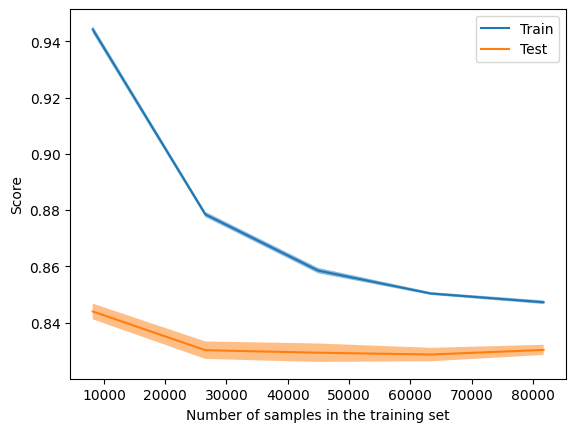

In [14]:
LearningCurveDisplay.from_estimator(
   clf_pipeline_LSVC, X_train, y_train)